# Automatizované určenie závažnosti dopravnej nehody

*Autori: Bc. Jakub Juško, Bc. Lukáš Radoský*

## Setup

Načítanie knižníc a datasetu z nášho google drive, konfigurácia knižníc.

In [0]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import operator

from datetime import date, datetime
import geopy.distance
from math import pi, tan
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import pylab as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams["figure.figsize"] = (16,8)
pd.options.display.float_format = '{:,.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Fáza - Predspracovanie

### Načítanie dát


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/US_Accidents_Dec19.csv"
df = pd.read_csv(path)

KeyboardInterrupt: ignored

Dátum: *18.04.2020*

Ciele odovzdania:
*   Predspracovanie a transformácia datasetu
*   Prieskum existujúcich prác
*   Natrénovanie a vyhodnotenie základného modelu

Podiel práce:
*   **Jakub Juško**: 50%
*   **Lukáš Radoský**: 50%


V tomto projekte sa pokúšame na základe rôznych údajov o dopravnej nehode predikovať závažnosť nehody. Vychádzame z datasetu [**US Accidents (3.0 million records)**](https://www.kaggle.com/sobhanmoosavi/us-accidents).

V predchádzajúcej fáze sme analyzovali dataset, poukázali na jeho zaujímavé vlastnosti a vytýčili zaujímavé atribúty.

V tejto fáze dataset predspracovávame, a na základe prieskumu existujúcich prác sme natrénovali základný regresný model, konkrétne rozhodovacie stromy (decision trees).

V rámci **predspracovania** vytvárame nové atribúty, akými je napríklad zaradenie nehody do sektorov na základe svetových strán (Sever, Juh, Juhovýchod,...) alebo boolovské atribúty indikujúce prítomnosť rôznych prvkov počasia. Tiež dopĺňame chýbajúce hodnoty atribútov, napríklad mediánom. Napokon opatrne odstraňujeme nepotrebné atribúty a záznamy s vychýlenými alebo chýbajúcimi hodnotami.

V rámci **trénovania** základného modelu rozhodovacích stromov rozdeľujeme dataset na trénovaciu a testovaciu množinu. Následne natrénujeme jednoduchý model, sledujúc metriky *accuracy*, *precision* a *F1 score*. Keďže sme ešte neladili model, nezvolili sme metriku, ktorú sa budeme snažiť optimalizovať. Prebežne predpokladáme, že zvolíme *F1 score*. Napokon od modelu zisťujeme, ktoré numerické atribúty mali najväčšiu váhu.

V časti *Setup* sa nachádza načítanie knižníc a dát. Časť *Predspracovanie a transformácia dát* detailne popisuje úkony prípravy datasetu pre model. Výsledky tejto časti zhŕňa časť *Prieskumná analýza po predspracovaní*, kde vidíme vlastnosti datasetu po jeho spracovaní. Následne popisujeme existujúce podobné práce v časti *Súvisiace práce*. Samotné trénovanie modelu a ukázanie jeho vlastností je v časti *Model*, pričom plány na jeho ďalšie trénovanie sú opísané v časti *Ďalšia práca*. Časť *Použitá literatúra* na záver uvádza referencie na existujúce práce.

## Predspracovanie a transformácia dát

### Úprava existujúcich atribútov

Zbavme sa atribútov, ktoré nás nezaujímajú. Jedná sa najmä o metaúdaje, alebo duplicitné atribúty (napr. 3 boolovské atribúty pojednávajú o tom, či počas nehody bol deň/noc, každý vychádza z inej definície dňa/noci).

In [0]:
interesting_attributes = ['Wind_Speed(mph)', 'Wind_Direction', 'Wind_Chill(F)', 'Visibility(mi)', 'Weather_Condition',
                          'Temperature(F)', 'Humidity(%)', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
                          'Distance(mi)', 'Description', 'Side', 'City', 'Pressure(in)', 'Precipitation(in)', 'Traffic_Signal',
                          'Sunrise_Sunset', 'Severity']

df = df.drop(columns=[column for column in df.columns if column not in interesting_attributes])

Viaceré atribúty, ktoré považujeme za zaujímavé, obsahujú chybajúce hodnoty. Najviac však stlpce **End_Lat** a **End_Lng**.

In [0]:
df.isnull().sum()

Severity                   0
Start_Time                 0
End_Time                   0
Start_Lat                  0
Start_Lng                  0
End_Lat              2246264
End_Lng              2246264
Distance(mi)               0
Description                1
Side                       0
City                      83
Temperature(F)         56063
Wind_Chill(F)        1852623
Humidity(%)            59173
Pressure(in)           48142
Visibility(mi)         65691
Wind_Direction         45101
Wind_Speed(mph)       440840
Precipitation(in)    1998358
Weather_Condition      65932
Traffic_Signal             0
Sunrise_Sunset            93
dtype: int64

Najskôr sa sme preto pokúsili doplniť niektoré chýbajúce hodnoty pomocou [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). Zvolili sme si stratégiu medián. Pre niektoré atribúty, ktoré sme odhadli ako menej dôležité pre náš model, nahradíme chýbajúce atribúty pomocou [**bfill**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) funkcie.

In [0]:
imr = SimpleImputer(missing_values=np.nan,strategy='median')
imr = imr.fit(df[['Humidity(%)']])
df['Humidity(%)'] = imr.transform(df[['Humidity(%)']]).ravel()

imr = imr.fit(df[['Pressure(in)']])
df['Pressure(in)'] = imr.transform(df[['Pressure(in)']]).ravel()

imr = imr.fit(df[['Wind_Chill(F)']])
df['Wind_Chill(F)'] = imr.transform(df[['Wind_Chill(F)']]).ravel()

imr = imr.fit(df[['Wind_Speed(mph)']])
df['Wind_Speed(mph)'] = imr.transform(df[['Wind_Speed(mph)']]).ravel()

imr = imr.fit(df[['Temperature(F)']])
df['Temperature(F)'] = imr.transform(df[['Temperature(F)']]).ravel()

In [0]:
df.fillna(method='bfill',inplace=True)

Overme si, či v prípade niektorých numerických atribútov prečistený dataset neobsahuje vychýlené hodnoty. Zaroveň sme zákódovali bool hodnoty na numerické, čo je vhodné pre neskôršie použitie pre náš model.

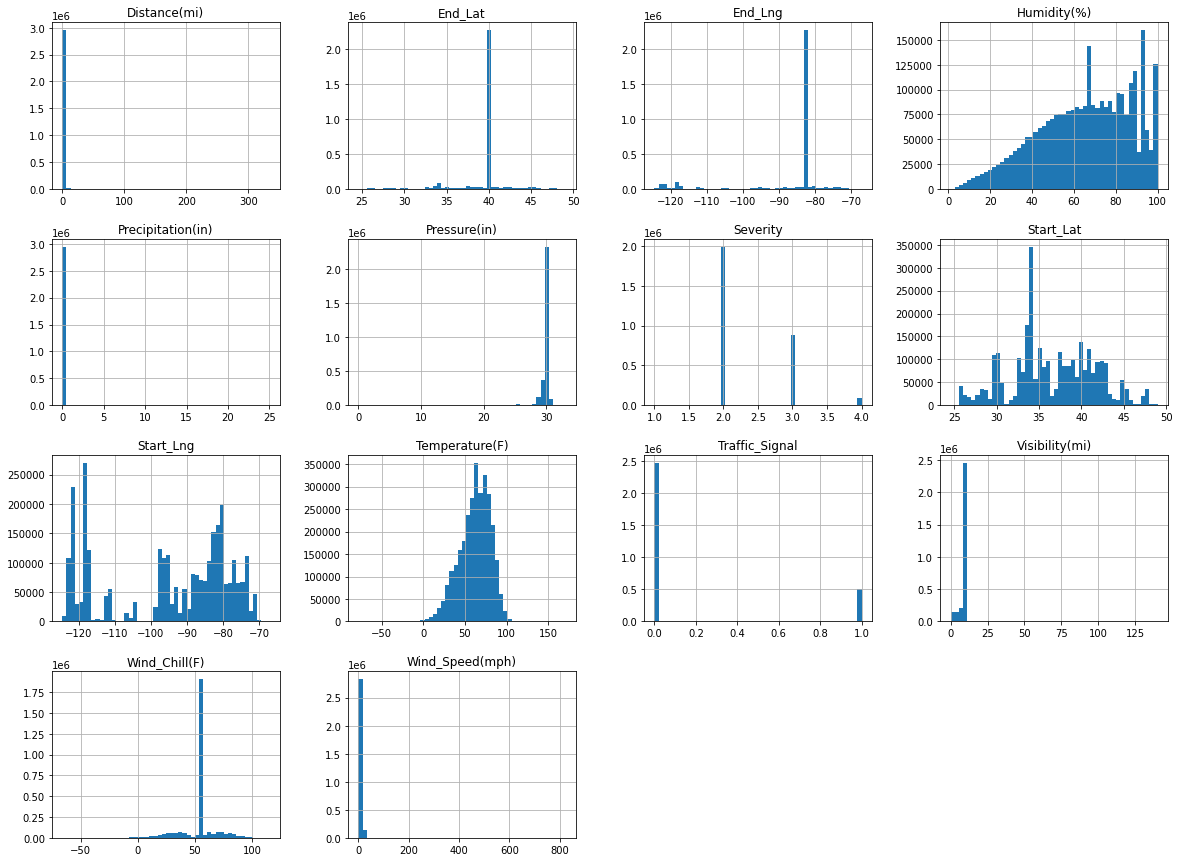

In [0]:
booleandf = df.select_dtypes(include=[bool])
booleanDictionary = {True: 1, False: 0}

for column in booleandf:
    df[column] = df[column].map(booleanDictionary)
_ = df.hist(figsize=(20, 15), bins=50)

Vidíme, že atribúty *Temperature*, *Wind_Chill* a *Humidity* majú rozdelenie **blížiace sa normálnemu rozdeleniu** a majú **iba minimálne vychýlené hodnoty**.

V prípade atribútov *Distance*, *Precipitation*, *Visibility*, *Wind_Speed*, *Pressure* a *Wind_Chill* vidíme **vychýlené hodnoty**, ktoré je potrebné odstrániť.

Rozdelenie atribútov *Start_Time*, *End_Time*, *Start_Lat*, *Start_Lng*,*End_Lat*, *End_Lng* nás nezaujíma, pretože tie budú transformované na iné atribúty.

*Severity*, teda závislá premenná pôsobí dosť nerovnomerne, avšak je typu **integer**, preto je daný diagram trochu zavádzajúci. Navyše k nej pristupujeme ako ku **kategorickému atribútu**. Preto jej hodnoty nepovažujeme za vychýlené a nebudeme odstraňovať záznamy na základe jej hodnôt.

Sledujme podrobnejšie frekvenciu výskytu hodnôt u atribútov s indikovanými vychýlenými hodnotami.

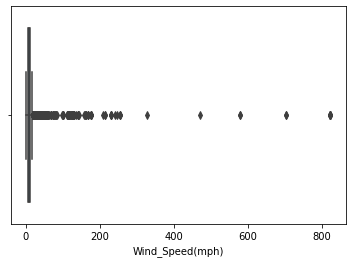

In [0]:
sns.boxplot(x=df['Wind_Speed(mph)'])

Za grafom sú zobrazené body od 100 , jedná sa o odľahlé hodnoty, pretože nie sú zahrnuté v rámčeku iného pozorovania, t.j. nie sú umiestnené blízko kvartilov.

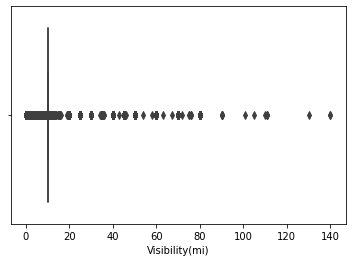

In [0]:
sns.boxplot(x=df['Visibility(mi)'])

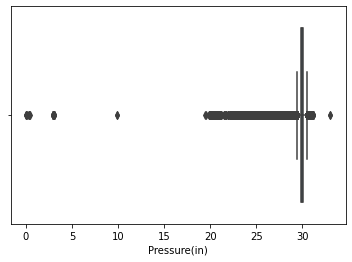

In [0]:
sns.boxplot(x=df['Pressure(in)'])

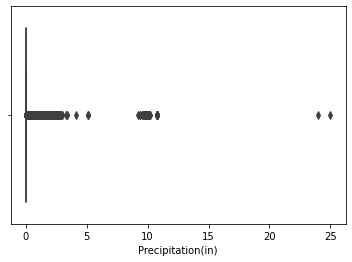

In [0]:
sns.boxplot(x=df['Precipitation(in)'])

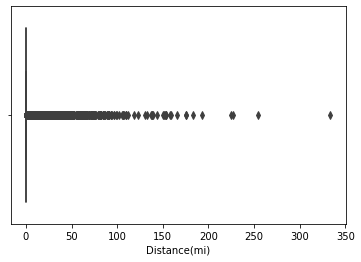

In [0]:
sns.boxplot(x=df['Distance(mi)'])

In [0]:
print('Počet záznamov pred spracovaním ' + str(len(df.index)))

df = df[df['Wind_Speed(mph)'] < 25]
df = df[df['Wind_Chill(F)']>0]
df = df[df['Visibility(mi)'] < 20]
df = df[df['Pressure(in)'] > 25]
df = df[df['Precipitation(in)'] < 1.5]
df = df[df['Distance(mi)'] < 40]

print('Počet záznamov po spracovaní ' + str(len(df.index)))

Počet záznamov pred spracovaním 2974335
Počet záznamov po spracovaní 2901566



Odstráňme teda pozorované vychýlené hodnoty u indikovaných atribútov. Vidime, že sme odstránili zanedbateľné množstvo záznamov.

Teraz sa pozrime na kategorické atribúty.

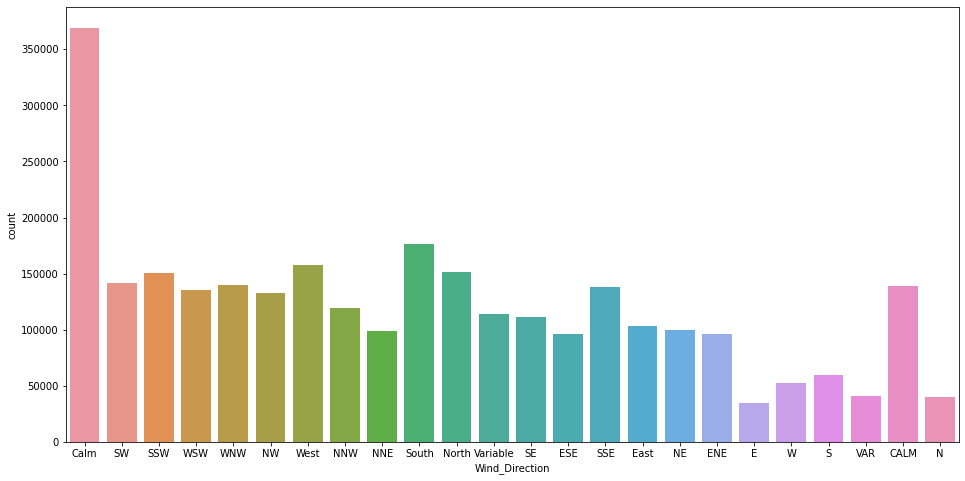

In [0]:
plt.figure(figsize=(16,8))
sns.countplot(df['Wind_Direction'])

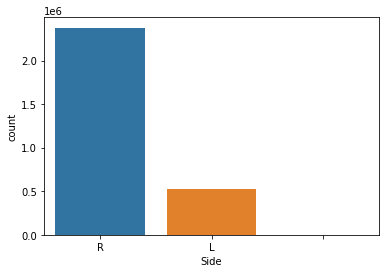

In [0]:
sns.countplot(df['Side'])

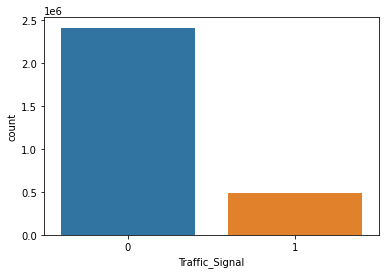

In [0]:
sns.countplot(df['Traffic_Signal'])

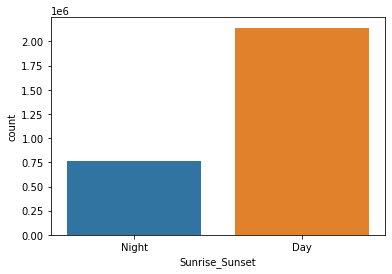

In [0]:
sns.countplot(df['Sunrise_Sunset'])

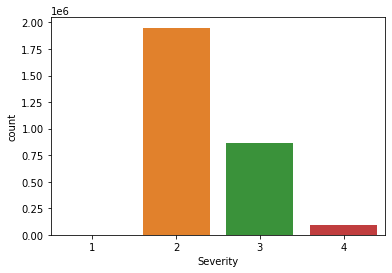

In [0]:
sns.countplot(df['Severity'])

Vidíme, že rozdelenie väčšiny (ak nie všetkých) je veľmi nerovnomerné, avšak to by nám nemalo prekážať. Narážame tu však na nekonzistenciu v atribúte *Wind_Direction*, kedy tá istá hodnota je vyjadrená rôzne, napríklad *S* a *South*. Napravme preto túto nekonzistenciu a pozrime sa ešte raz na jej rozdelenie. Okrem výrazne vyššieho výskytu hodnoty *CALM* je rozdelenie hodnôt značne rovnomerné.

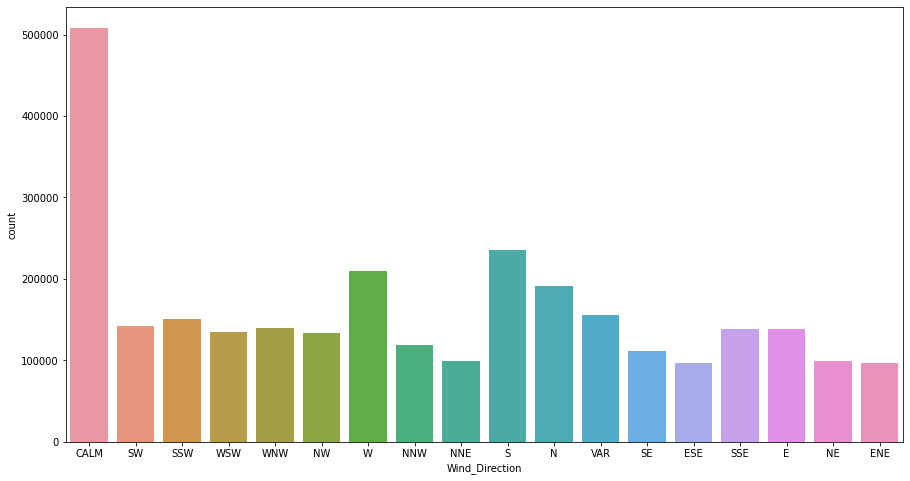

In [0]:
correction_dict = {
    "South"     : "S",
    "North"     : "N",
    "East"      : "E",
    "West"      : "W",
    "Variable"  : "VAR",
    "Calm"      : "CALM"
}
df['Wind_Direction'] = df['Wind_Direction'].apply(lambda x: correction_dict[x] if x in correction_dict else x)
plt.figure(figsize=(15,8))
sns.countplot(df['Wind_Direction'])

### Tvorba nových atribútov

Po zbavení sa nezaujímavých atribútov a záznamov môžeme vytvárať nové atribúty na základe tých existujúcich. Zároveň hneď kontrolujeme rozdelenie hodnôt vytvorených atribútov a vykonáme prípadné úpravy.

#### Duration

Kombináciou atribútov *Start_Time* a *End_Time* vytvorme atribút *Duration*. Touto transformáciou vzniklo niekoľko extrémne vychýlených hodnôt. Ihneď sme ich odstránili, pretože robili akúkoľvek vizualizáciu zbytočnou.

Vidíme, že rozdelenie by sa blížilo normálnemu, ak by sme záznamy s hodnotou nad približne 250000 odstránili. Nepovažujeme však za nutné odstrániť všetko, čo narúša podobnosť s normálnym rozdelením.

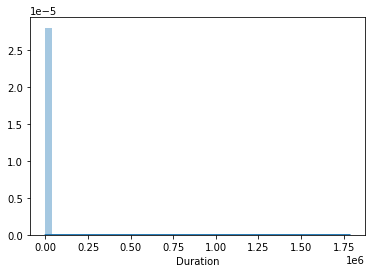

In [0]:
duration = pd.to_datetime(df['End_Time'], format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S')
df['Duration'] = duration.astype('timedelta64[m]')
sns.distplot(df['Duration'])

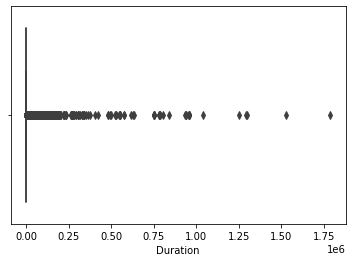

In [0]:
sns.boxplot(df['Duration'])

In [0]:
print("Počet záznamov pred úpravou: " + str(len(df.index)))
df = df[df['Duration'] < 250000]
print("Počet záznamov po úprave: " + str(len(df.index)))

Počet záznamov pred úpravou: 2901566
Počet záznamov po úprave: 2901493


#### Season

Z atribútu *Start_Time*(rovnako by to šlo s *End_Time*) vytvorme **kategorický** atribút *Season*, indikujúci ročné obdobie, v ktorom došlo k nehode. Jeho rozdelenie sa zdá byť v poriadku.

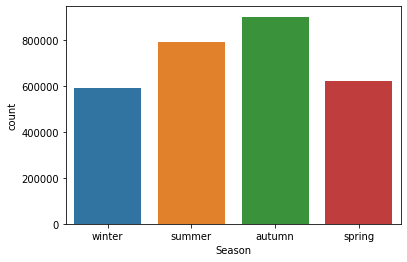

In [0]:
Y = 2000
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
def get_season(start):
    now = date(Y, start.month, start.day)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

df['Season'] = [get_season(datetime.strptime(start, "%Y-%m-%d %H:%M:%S").date()) for start in df['Start_Time']]
sns.countplot(df['Season'])

#### Day part

Z atribútu *Start_Time*(rovnako by to šlo s *End_Time*) vytvorme **kategorický** atribút *Day_Part*, indikujúci časť dňa, počas ktorej došlo k nehode. Zaradenie do časti dňa na základe hodiny vychádza z [tejto stránky](https://learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc)

V rozdelení hodnôt nepozorujeme nič nezvyčajné, okrem výrazne nižšieho zastúpenia hodnôt *Late Night*, *Late Morning*, a menej výrazne nižšieho zastúpenia hodnoty *Evening*/*Night*. To však nie je problémom, ktorý by bolo potrebné riešiť.



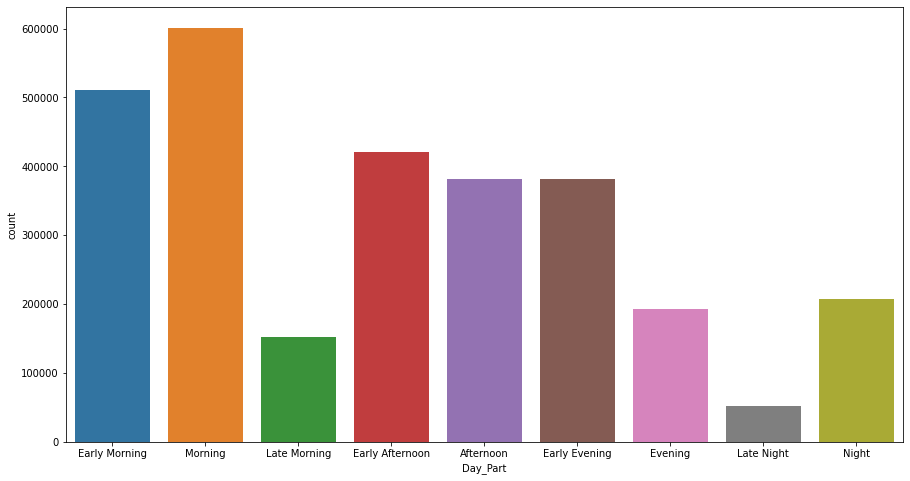

In [0]:
day_parts = [
    [0, "Night"],
    [4, "Late Night"],
    [5, "Early Morning"],
    [8, "Morning"],
    [11, "Late Morning"],
    [12, "Early Afternoon"],
    [15, "Afternoon"],
    [16, "Afternoon"],
    [17, "Early Evening"],
    [19, "Evening"],
    [21, "Night"],
    [24, "Night"]
]
def get_day_part(hour):
    i = 0
    current = day_parts[0][1]

    while not (hour >= day_parts[i][0] and hour < day_parts[i + 1][0]):
      i = i + 1
      current = day_parts[i][1]
    return current

df['Day_Part'] = [get_day_part(datetime.strptime(start, "%Y-%m-%d %H:%M:%S").hour) for start in df['Start_Time']]
plt.figure(figsize=(15,8))
sns.countplot(df['Day_Part'])

#### Year - *Zahadzujeme*

Z atribútu *Start_Time*(rovnako by to šlo s *End_Time*) vytvorme **numerický** atribút *Year*, indikujúci rok, v ktorom došlo nehode.

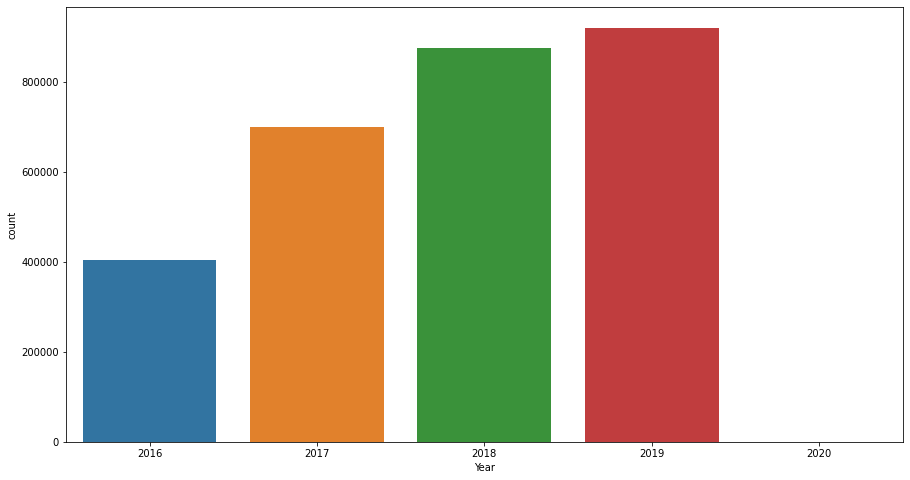

In [0]:
df['Year'] = [datetime.strptime(start, "%Y-%m-%d %H:%M:%S").year for start in df['Start_Time']]
plt.figure(figsize=(15,8))
sns.countplot(df['Year'])
df = df.drop(columns = ['Year'])


Na základe vizualizácie ako aj retrospektívy musíme konštatovať, že tento atribút skôr reflektuje, kedy boli záznamy zbierané, nie kedy došlo k nehodám. Preto tento atribút nepoužijeme.

#### Leap_Year

Z atribútu *Start_Time*(rovnako by to šlo s *End_Time*) vytvorme **numerický (bool)** atribút *Leap_Year*, indikujúci, či sa nehoda udiala v prestupnom roku.

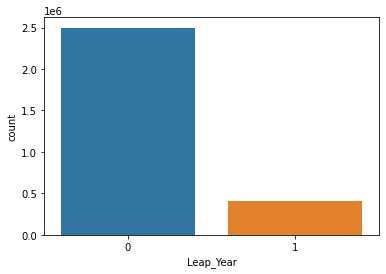

In [0]:
def is_leap_year(year):
    if (year % 4 != 0):
      return 0
    if (year % 100 != 0):
      return 1
    if (year % 400 != 0):
      return 0
    return 1

df['Leap_Year'] = [is_leap_year(datetime.strptime(start, "%Y-%m-%d %H:%M:%S").year) for start in df['Start_Time']]
sns.countplot(df['Leap_Year'])

Rozdelenie je, podľa učakávania, veľmi nerovnomerné. Je preto možné, že tento atribút nepoužijeme.

#### Cardinal_Direction

Z atribútov *Start_Lattitude* a *Start_Longitude* určíme, či sa nehoda udiala na Severe, Severozápade atď. sledovanej oblasti. Vytvoríme tak **kategorický** atribút *Cardinal_Direction*. 

In [0]:
lat_max = df['Start_Lat'].max()
lat_min = df['Start_Lat'].min()
lng_max = df['Start_Lng'].max()
lng_min = df['Start_Lng'].min()

lat_range = abs(lat_max - lat_min)
lng_range = abs(lng_max - lng_min)

lat_middle = lat_min + lat_range / 2
lng_middle = lng_min + lng_range / 2

dlat = 2 * lng_range / 2 * lat_range / 2 / lng_range / 2
dlng = 2 * lng_range / 2 * lat_range / 2 / lat_range / 2

points = [
  (lat_middle + dlat, lng_max),
  (lat_max, lng_middle + dlng),
  (lat_max, lng_middle - dlng),
  (lat_middle + dlat, lng_min),
  (lat_middle - dlat, lng_min),
  (lat_min, lng_middle - dlng),
  (lat_min, lng_middle + dlng),
  (lat_middle - dlat, lng_max),
  (lat_middle + dlat, lng_max)
]

def GenerateTriangles():
  triangles = []
  previous = None
  for point in points:
    if previous is None:
      previous = point
      continue
    triangles.append((previous, point, (lat_middle, lng_middle)))
    previous = point
  
  return triangles

triangles = GenerateTriangles()

def get_triangle_index(pt):
  for i in range(len(triangles)):
    #print(str(pt) + " : " + str(triangles[i]))
    if(Polygon(triangles[i]).contains(Point(pt))):
      return i
  return 0

temp = [[], [], [], [], [], [], [], []]
cardinal_directions = ["NE", "N", "NW", "W", "SW", "S", "SE", "E"]
temp_2 = []

for Start_Lat, Start_Lng in zip(df.Start_Lat, df.Start_Lng):
  triangle_index = get_triangle_index((Start_Lat, Start_Lng))
  temp[triangle_index].append((Start_Lng, Start_Lat))
  temp_2.append(cardinal_directions[triangle_index])



In [0]:
df["Cardinal_Direction"] = temp_2

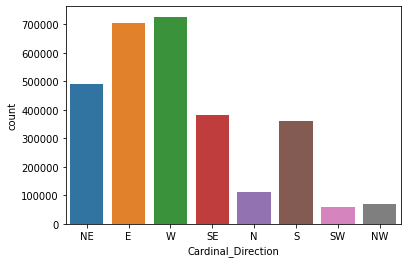

In [0]:
sns.countplot(df['Cardinal_Direction'])

Môžeme pozorovať, že veľká časť nehôd sa udiala na západe a východe, pričom minimum na juhozápade, severozápade a severe. Dokladá to aj efektná vizualizácia v priestore, rozdelená na jednotlivé sektory.

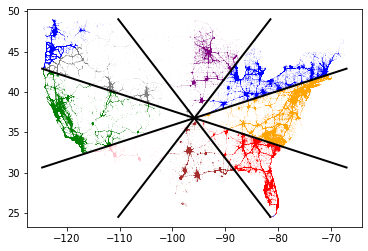

In [0]:
colors = ["blue", "purple", "grey", "green", "pink", "brown", "red", "orange"]

i = 0
for t in temp:
  plt.plot([x for (x, _) in t], [y for (_, y) in t], ".",color=colors[i], alpha=0.2, markersize=0.1)
  i += 1

plt.plot([points[0][1], points[4][1]], [points[0][0], points[4][0]], color='k', linewidth=2)
plt.plot([points[1][1], points[5][1]], [points[1][0], points[5][0]], color='k', linewidth=2)
plt.plot([points[2][1], points[6][1]], [points[2][0], points[6][0]], color='k', linewidth=2)
plt.plot([points[3][1], points[7][1]], [points[3][0], points[7][0]], color='k', linewidth=2)
#plt.legend(loc='best')
plt.show()

#### Winter_Conditions

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Winter_Conditions* indikujúci, či v čase nehody snežilo, príp. bola zľadovatelá cesta, alebo nie. Podľa očakávanie, rozdelenie je značne nerovnomerné.

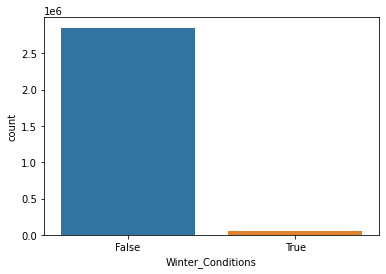

In [0]:
df['Winter_Conditions'] = ["ice" in x.lower() or "snow" in x.lower() or "wint" in x.lower() or "sleet" in x.lower() or "freez" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Winter_Conditions'])

#### Rain

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Rain* indikujúci, či v čase nehody pršalo. Podľa očakávania, rozdelenie je značne nerovnomerné, ale menej ako pri *Winter_Conditions*.

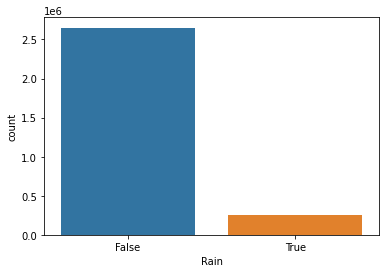

In [0]:
df['Rain'] = ["rain" in x.lower() or "haze" in x.lower() or "drizzle" in x.lower() or "sleet" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Rain'])

#### Fog

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Fog* indikujúci, či v čase nehody bola hmla. Rozdelenie je značne nerovnomerné.

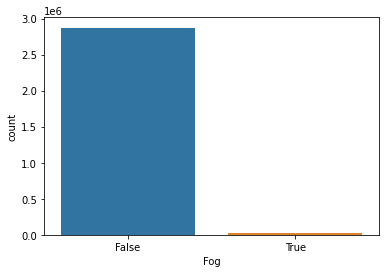

In [0]:
df['Fog'] = ["mist" in x.lower() or "fog" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Fog'])

#### Clouds

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Clouds* indikujúci, či v čase nehody bolo oblačno. Rozdelenie je pomerne rovnomerné.

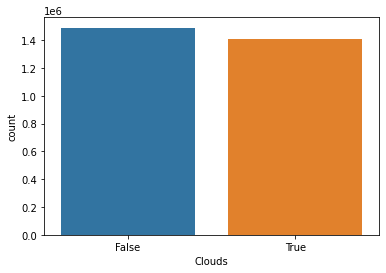

In [0]:
df['Clouds'] = ["cloud" in x.lower() or "overcast" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Clouds'])

#### Storm

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Storm* indikujúci, či v čase nehody bola búrka. Rozdelenie je značne nerovnomerné.

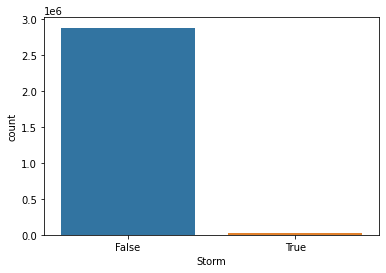

In [0]:
df['Storm'] = ["storm" in x.lower() or "thunder" in x.lower() or "squall" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Storm'])

#### Wind

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Wind* indikujúci, či v čase nehody bolo veterno. Rozdelenie je značne nerovnomerné.

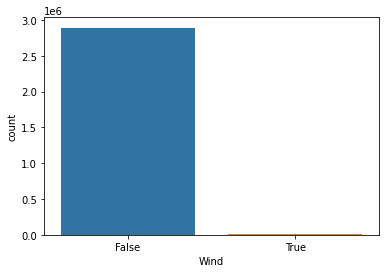

In [0]:
df['Wind'] = ["wind" in x.lower() or "blow" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Wind'])

#### Particles

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Particles* indikujúci, či v čase nehody zasahovali čiastočky ako piesok, dym, popol alebo prach. Rozdelenie je značne nerovnomerné.

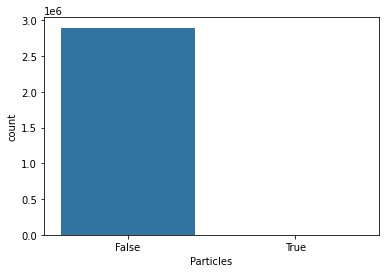

In [0]:
df['Particles'] = ["sand" in x.lower() or "smok" in x.lower()  or "ash" in x.lower()   or "dust" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Particles'])

#### Favorable_Weather

Z atribútu "Weather_Condition" vytvoríme **boolovský atribút** *Favorable_Weather* indikujúci, či v čase nehody bola hmla. Rozdelenie je rovnomerné.

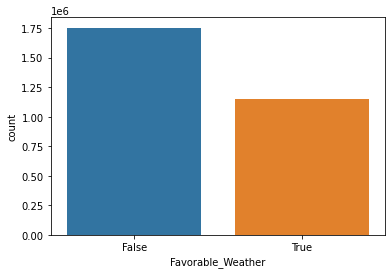

In [0]:
df['Favorable_Weather'] = ["fair" in x.lower() or "clear" in x.lower() for x in df['Weather_Condition']]
sns.countplot(df['Favorable_Weather'])

#### Blocked_Lane

Z atribútu "Description" vytvoríme **boolovský atribút** *Blocked_Lane* indikujúci, či nehodou došlo k zablokovaniu pruhu. Rozdelenie je nerovnomerné.

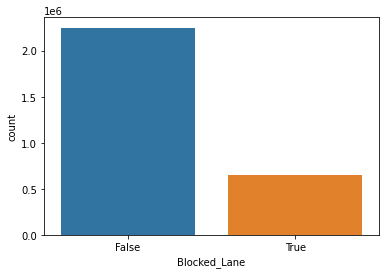

In [0]:
df['Blocked_Lane'] = ["blocked" in x.lower() and "lane" in x.lower() for x in df['Description']]
sns.countplot(df['Blocked_Lane'])

#### Closed_Lane

Z atribútu "Description" vytvoríme **boolovský atribút** *Closed_Lane* indikujúci, či nehodou došlo k uzavratiu pruhu. Rozdelenie je značne nerovnomerné.

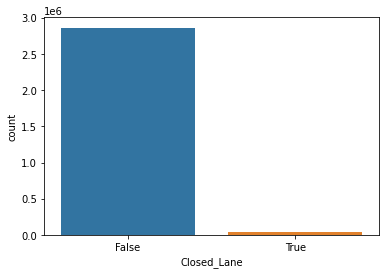

In [0]:
df['Closed_Lane'] = ["closed" in x.lower() and "lane" in x.lower() for x in df['Description']]
sns.countplot(df['Closed_Lane'])

### Zahodenie atribútov

Niektoré pôvodné atribúty sme si ponechali len preto, aby sme na ich základe vytvorili nové atribúty. Keďže sme vytváranie už vykonali, môžeme tieto atribúty odstrániť.

In [0]:
df = df.drop(columns = ['Weather_Condition', 'Description','Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'])

## Prieskumná analýza po predspracovaní

Po predspracovaní datasetu sa znovu pozrime na naše dáta a sledujme, ako sa zmenili.

Najskôr si urobme jednoduchý prehľad atribútov a ich typov.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2901493 entries, 0 to 2974334
Data columns (total 29 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Severity            int64  
 1   Distance(mi)        float64
 2   Side                object 
 3   City                object 
 4   Temperature(F)      float64
 5   Wind_Chill(F)       float64
 6   Humidity(%)         float64
 7   Pressure(in)        float64
 8   Visibility(mi)      float64
 9   Wind_Direction      object 
 10  Wind_Speed(mph)     float64
 11  Precipitation(in)   float64
 12  Traffic_Signal      int64  
 13  Sunrise_Sunset      object 
 14  Duration            float64
 15  Season              object 
 16  Day_Part            object 
 17  Leap_Year           int64  
 18  Cardinal_Direction  object 
 19  Winter_Conditions   bool   
 20  Rain                bool   
 21  Fog                 bool   
 22  Clouds              bool   
 23  Storm               bool   
 24  Wind                bool

Pozrime sa naskôr na malú ukážku niekoľkých záznamov.

In [0]:
df.head(5)

,Severity,Distance(mi),Side,City,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Traffic_Signal,Sunrise_Sunset,Duration,Season,Day_Part,Leap_Year,Cardinal_Direction,Winter_Conditions,Rain,Fog,Clouds,Storm,Wind,Particles,Favorable_Weather,Blocked_Lane,Closed_Lane
0,3,0.01,R,Dayton,36.90,54.00,91.00,29.68,10.00,CALM,7.00,0.02,0,Night,314.00,winter,Early Morning,1,NE,False,True,False,False,False,False,False,False,True,False
1,2,0.01,L,Reynoldsburg,37.90,54.00,100.00,29.65,10.00,CALM,7.00,0.00,0,Night,30.00,winter,Early Morning,1,NE,False,True,False,False,False,False,False,False,False,False
2,2,0.01,R,Williamsburg,36.00,33.30,100.00,29.67,10.00,SW,3.50,0.03,1,Night,30.00,winter,Early Morning,1,E,False,False,False,True,False,False,False,False,False,False
3,3,0.01,R,Dayton,35.10,31.00,96.00,29.64,9.00,SW,4.60,0.03,0,Night,30.00,winter,Early Morning,1,NE,False,False,False,True,False,False,False,False,False,False
4,2,0.01,R,Dayton,36.00,33.30,89.00,29.65,6.00,SW,3.50,0.03,1,Day,30.00,winter,Early Morning,1,NE,False,False,False,True,False,False,False,False,False,False


Sledujme prehľad numerických atribútov.

In [0]:
df.describe(include=np.number)

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Traffic_Signal,Duration,Leap_Year
count,"2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00","2,901,493.00"
mean,2.36,0.27,62.95,53.55,65.61,29.87,9.06,7.99,0.02,0.17,105.25,0.14
std,0.54,1.27,17.94,14.49,22.29,0.55,2.28,4.24,0.07,0.38,"1,242.18",0.35
min,1.00,0.00,-77.80,0.10,1.00,25.01,0.00,0.00,0.00,0.00,-35.00,0.00
25%,2.00,0.00,51.10,54.00,50.00,29.83,10.00,5.80,0.00,0.00,29.00,0.00
50%,2.00,0.00,64.40,54.00,67.00,29.98,10.00,7.00,0.00,0.00,44.00,0.00
75%,3.00,0.01,76.00,54.00,84.00,30.11,10.00,10.40,0.01,0.00,74.00,0.00
max,4.00,39.99,170.60,115.00,100.00,33.04,19.00,24.20,1.49,1.00,"237,467.00",1.00


A prehľad nominálnych atribútov.

In [0]:
df.describe(exclude=np.number)

,Side,City,Wind_Direction,Sunrise_Sunset,Season,Day_Part,Cardinal_Direction,Winter_Conditions,Rain,Fog,Clouds,Storm,Wind,Particles,Favorable_Weather,Blocked_Lane,Closed_Lane
count,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493,2901493
unique,3,11569,18,2,4,9,8,2,2,2,2,2,2,2,2,2,2
top,R,Houston,CALM,Day,autumn,Morning,W,False,False,False,False,False,False,False,False,False,False
freq,2376378,93137,508326,2141162,900480,601215,726800,2852281,2650725,2872235,1489545,2878147,2892562,2897645,1753236,2248746,2860612


Pre účely trénovania nášho modelu sme previedli všetky boolean hodnoty na čísla.

In [0]:
booleandf = df.select_dtypes(include=[bool])
booleanDictionary = {True: 1, False: 0}

for column in booleandf:
    df[column] = df[column].map(booleanDictionary)

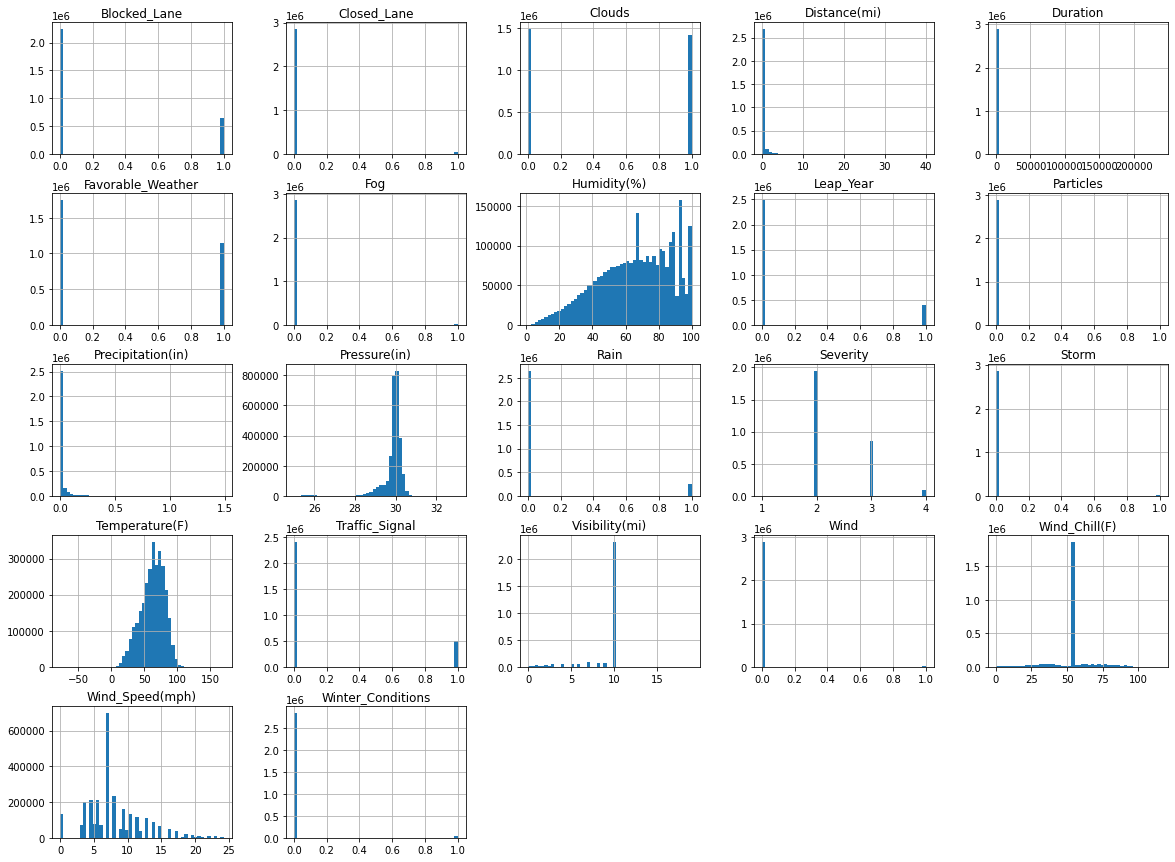

In [0]:
_ = df.hist(figsize=(20, 15), bins=50)

Overme si, čo nám po úpravách stále nechýbajú nejaké hodnoty. Zisťujeme že tento problém sme z datasetu úspešne odstránili.

In [0]:
df.isnull().sum()

Severity              0
Distance(mi)          0
Side                  0
City                  0
Temperature(F)        0
Wind_Chill(F)         0
Humidity(%)           0
Pressure(in)          0
Visibility(mi)        0
Wind_Direction        0
Wind_Speed(mph)       0
Precipitation(in)     0
Traffic_Signal        0
Sunrise_Sunset        0
Duration              0
Season                0
Day_Part              0
Leap_Year             0
Cardinal_Direction    0
Winter_Conditions     0
Rain                  0
Fog                   0
Clouds                0
Storm                 0
Wind                  0
Particles             0
Favorable_Weather     0
Blocked_Lane          0
Closed_Lane           0
dtype: int64

Pre zaujímavosť sa pozrime na koreláciu medzi jednotlivými numerickými (a teda aj boolovskými) atribútmi. Často môžeme pozorovať vysokú koreláciu medzi súvisiacimi fyzikálnymi veličinami. Tiež vidíme vysokú zápornú koreláciu medzi boolovskými atribútmi *Favorable Weather* a *Clouds*, ktoré si logicky odporujú. To nám aspoň potvrdzuje, že hodnoty týchto atribútov sú zväčša validné.

Zaujímavá je korelácia závislej premennej *Severity* s ostatnými atribútmi. Zvýšené hodnoty ukazujú atribúty *Distance* a *Blocked_Lane*, čo dáva zmysel - zablokovanie pruhu a zasiahnutie väčšieho úseku nehodou jednoznačne popisuje závažnejšiu nehodu. Zvýšená korelácia, i keď záporná, je s atribútom *Traffic_Signal*. Z toho vyplýva, že v blízkosti semafórov dochádza k menej závažným nehodám, čo potvrdzuje validitu semafórov ako bezpečnostného prvku v doprave.

Zvýšené hodnoty korelácie sú zvýraznené v ďalšom zobrazení.

In [0]:
df.corr()

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Traffic_Signal,Duration,Leap_Year,Winter_Conditions,Rain,Fog,Clouds,Storm,Wind,Particles,Favorable_Weather,Blocked_Lane,Closed_Lane
Severity,1.00,0.16,-0.02,-0.04,0.03,0.04,-0.01,0.02,0.02,-0.20,0.02,0.01,0.02,0.02,-0.01,0.01,0.01,-0.00,-0.00,-0.03,0.20,0.07
Distance(mi),0.16,1.00,-0.04,-0.04,0.02,-0.02,-0.02,0.01,0.01,-0.08,0.03,-0.01,0.04,0.01,0.00,-0.01,0.00,0.00,-0.00,-0.01,0.02,0.04
Temperature(F),-0.02,-0.04,1.00,0.71,-0.34,-0.11,0.23,0.00,0.06,0.05,0.00,0.10,-0.26,-0.08,-0.06,0.02,0.06,-0.00,0.01,0.09,0.03,-0.04
Wind_Chill(F),-0.04,-0.04,0.71,1.00,-0.19,-0.25,0.17,-0.12,-0.02,0.02,-0.00,-0.04,-0.29,-0.04,-0.02,-0.04,0.05,0.02,0.01,0.12,0.05,-0.03
Humidity(%),0.03,0.02,-0.34,-0.19,1.00,0.08,-0.42,-0.14,0.10,-0.02,-0.00,-0.03,0.12,0.28,0.14,0.10,0.06,-0.02,-0.04,-0.32,-0.00,-0.00
Pressure(in),0.04,-0.02,-0.11,-0.25,0.08,1.00,0.01,0.01,0.04,0.01,-0.00,0.11,-0.01,-0.03,-0.01,0.03,-0.02,-0.08,-0.00,-0.01,0.01,-0.05
Visibility(mi),-0.01,-0.02,0.23,0.17,-0.42,0.01,1.00,0.03,-0.11,0.03,0.00,0.05,-0.35,-0.45,-0.33,0.15,-0.09,-0.00,-0.03,0.26,0.00,-0.01
Wind_Speed(mph),0.02,0.01,0.00,-0.12,-0.14,0.01,0.03,1.00,0.03,0.02,0.01,0.01,0.07,0.05,-0.07,0.09,0.03,0.18,-0.00,-0.12,0.01,0.01
Precipitation(in),0.02,0.01,0.06,-0.02,0.10,0.04,-0.11,0.03,1.00,0.00,0.01,0.01,-0.01,0.14,-0.01,-0.00,0.14,-0.01,-0.01,-0.08,-0.00,0.00
Traffic_Signal,-0.20,-0.08,0.05,0.02,-0.02,0.01,0.03,0.02,0.00,1.00,-0.01,-0.01,-0.02,-0.02,-0.01,0.03,0.00,-0.00,-0.01,-0.01,-0.09,-0.03


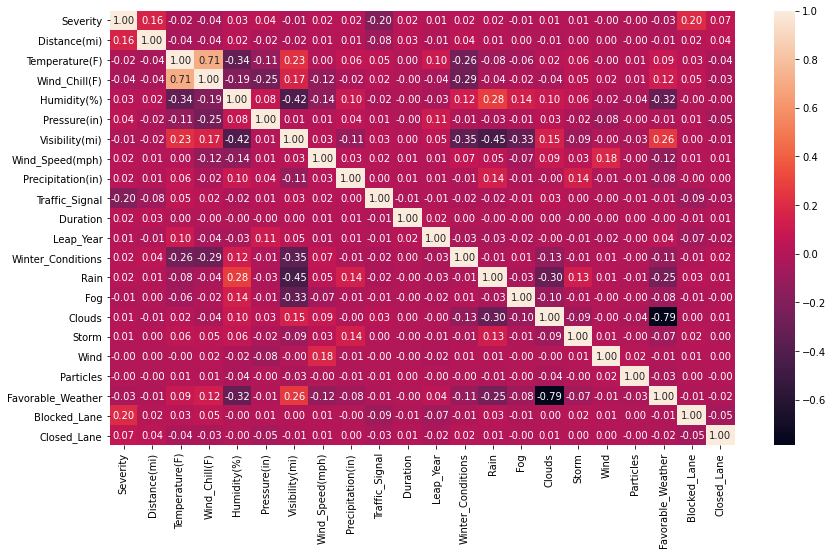

In [0]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df.corr(),ax=ax,annot=True, fmt=".2f")

Napokon si ešte raz pripomeňme rozdelenie hodnôt závislej premennej.

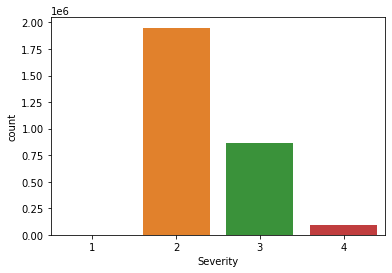

In [0]:
sns.countplot(df['Severity'])

Aj konkrétne percentuálne zastúpenie jednotlivých tried. Toto bude zaujímavé najmä v kontexte porovnania s jednou z prác[3].

In [0]:
df['Severity'].value_counts(normalize=True, ascending = False) * 100


2   67.22
3   29.69
4    3.06
1    0.03
Name: Severity, dtype: float64

## Súvisiace práce

Autori nasledovných článkov sa venovali podobnému problému - predikcii závažnosti dopravnej nehody. Každý z nižšie spomenutých článkov opisuje nimi použite prístupy a modely, ako ich výsledky.

### Accident Severity Prediction using Data Mining Methods [1]

S. Ramya a kol. študovali rôzne parametre ovplyvňujúce závažnosť dopravných nehôd a zistili, že klasifikátor *RandomForest* prekonal svoje náprotivky *DecisionTree* a *ANN* pri zvládaní predikcie závažnosti nehôd.

Ako jednu z čŕt použili napr. *Weather Conditions*, ktorými disponuje aj náš dataset.

Na úspešnosť klasifikátorov vyhodnocovali metrikami accuracy, precision, recall and F1.

| Algoritmus     | Spôsob evaluácie | Počet čŕt  | Accuracy (%) | Precision (%) | Recall (%) | F1 (%) |
|----------------|------------------|------------|--------------|---------------|------------|--------|
| Decission tree | 10-fold CV       | 8          | 66.24        | 63.5          | 69.0       | 69.0   |
| ANN            | 10-fold CV       | 8          | 61.24        | 59.5          | 61.0       | 69.0   |
| RandomForest   | 10-fold CV       | 8          | **71.24**        | **69.5**          | **71.0**       | **79.0**   |

Z vyššie uvedenej tabuľky je teda zrejmé, že *RandomForest* má najvyššiu úspešnosť na všetkých vyhodnocovaných metrikách. Okrem toho autori skonštatovali, že úspešnosť bola horšia pre menšie triedy (fatálne a vážne nehody) a skreslená pre hlavnú triedu (mierne nehody) kvôli skosenej distribúcii údajov medzi triedami na nevyváženom pôvodnom datasete.

### Severity prediction of traffic accidents with recurrent neural networks [2]

M. Sameen a  B. Pradhan vyvinuli model strojového učenia s využitím rekurentnej neurónovej siete (RNN) na predpovedanie závažnosti dopravných nehôd na základe vzorky 1 130 záznamov o nehodách, ktoré sa vyskytli na severojužnej rýchlostnej ceste (NSE) v Malajzii v rokoch 2009 až 2015. Navrhovaný *RNN* model bol porovnaný s viacvrstvovým perceptrónom (*MLP*) a Bayesovskou logistickou regresiou (*BLR*), aby pochopili jeho výhody a obmedzenia. 

Výsledky porovnávacích analýz ukázali, že *RNN* model prekonal modely *MLP* a *BLR*. Presnosť validácie *RNN* modelov bola **71,77%**, zatiaľ čo modely *MLP* a *BLR* dosiahli **65,48%** a **58,30%**. Ako metriku využili *Accuracy*.

### Learning the classification of traffic accident types [3]

Hlavným cieľom výskumu T. Beshah a kol. bolo vyvinúť *fuzzy* klasifikátor v spojení s genetickým programovaním, ktorý by označoval údaje v datasete. Údaje o cestnej nehode boli získané z dopravného úradu Addis Abeba. Dataset zachytáva viac ako 12 336 dopravných nehôd, ku ktorým došlo v Etiópii v období medzi rokmi 1998 a 2000.

Záznam o každej nehode obsahuje informácie o čase nehody (napr. rok, mesiac, týždeň, deň, hodina), príslušné vozidlo (napr. typ vozidla, technický stav), vodič vozidla (napr. vek vodiča, zážitok z jazdy), miesto nehody a miestne podmienky (napr. stav vozovky, orientácia na vozovku, poveternostné podmienky) a obeť nehody (napr. typ obete, typ zrážky, závažnosť zranenia). Niekoľko atribútov v množine údajov je číselných (napr. rok nehody) a ostatné sú kategorické (napr. typ vozidla). Nehody sú klasifikované podľa závažnosti do štyroch tried: nehody s úrazmi, nehody s následkom zranenia, smrteľné nehody a nehody s neznámou závažnosťou. 
Cieľom teda nebolo vyvinuť klasifikátor, ktorý by bol určený na označovanie dopravných nehôd v reálnom čase (najmä preto, že závažnosť nehody je zvyčajne známa už v čase, keď sú údaje k dispozícii), ale skôr na zobrazenie atribútov a vzťahov medzi atribútmi, ktoré boli kľúčové pri nehode.

Použili *fuzzy* klasifikátor na označovanie rôznych tried dopravných nehôd. Triedy sú 3 -  *No injury*, *Injury* a *Fatal*, doplnené o triedu *Unknown*, v ktorej sa však ocitli len 3 záznamy.
Experimentálne výsledky ukazujú, že model môže klasifikovať nehody so sľubnou presnosťou. Najúspešnejší klasifikátor použil iba 13 atribútov z 43 dostupných atribútov a dosiahol presnosť(*precision*) **94,2%**.

Vysoká presnosť klasifikácie je pozoruhodná. Ich model však **chybne klasifikoval jednu celú triedu** - *Fatal*. Dataset bol značne nevyvážený a táto trieda tvorila 4.5% datasetu. Klasifikátor sa teda naučil veľmi dobre rozlišovať medzi triedami *No injury* a *Injury*, avšak jednu triedu(*Fatal*) úplne odignoroval. Hodnota metriky teda je pravdivá, avšak je k nej nutné spomenúť obmedzenia modelu. K hodnote metriky mohla prispieť aj nevyváženosť datasetu.
Klasifikátor mal teda "záchrannú triedu" *No injury*, do ktorej bolo najbezpečnejšie zaradiť záznam. Samozrejme sa jedná len o úvahu, a nevieme ju potvrdiť, ani vyvrátiť. Vysokú presnosť modelu to však prinajmenšom spochybňuje.

Pozoruhodná je **podobnosť rozdelenia ich datasetu** s rozdelením nášho datasetu.

|    Trieda  | Náš dataset (%) | Dataset tejto práce (%)|
|------|:----------:|------------|
| Najmenej závažná | 0.03 | N/A|
| Menej závažná |  67.22  | 77.41|        
| Závažnejšia   | 29.69  | 18.09    |
| Najzávažnejšia   |3.06  | 4.5    |

Role jednotlivých úrovní závažnosti nehody (dominantná hodnota, menej frekventovaná, minimálne prítomná) sú len trocha relatívne posunuté. Musíme si preto dať pozor na podobné problémy, i keď rozdelenie hodnôt nášho datasetu je o trochu rovnomernejšie.

Ako ďalšiu možnú prácu uvádzajú, že by sa pre každú triedu mohol spraviť samostatný klasifikátor na dosiahnutie lepšej presnosti a citlivosti označenia.

### Mining Road Traffic Accident Data to Improve Safety [4]

Na predpovedanie závažnosti nehôd použili T. Beshah a Sh. Hill naivné klasifikačné algoritmy. Klasifikačné modely boli vytvorené pomocou *Decision Tree*, *Naive Bayes* a  K-najbližšich susedov (*KNN*). Zhromaždili a vyčistili údaje o dopravnej nehode a testovali prediktívné modely. Ich klasifikácia je založená na faktoroch súvisiacich s cestou, ako sú orientácia cesty, oddelenie cesty, typ povrchu cesty a stav povrchu vozovky. V tomto zistili, že zavážnosť nehôd bola vyššia pri nehodách, ktoré sa vyskytli bližšie k obytným zónam.

V experimente bol použitý dataset obsahujúci záznamy o 18 288 nehôd s 10 atribútmi vrátane 9 nezávislých premenných a závislej premennej (atribút *AccidentSeverity*).


| Algoritmus     | Počet úspešne klasifikovaných inštancií  | Accuracy (%)|
|------|:----------:|------------|
| Decision tree | 14 666| 80.221|
| Naive Bayes |  14 625  | 79.9967|        
| KNN   |**14 777**  | **80.8182**    |

Tabuľka vyššie  ukazuje, že použitím naivného *Bayesovho klasifikátora* bola dosiahnutá presnosť **79,9967 %**. Použitím klasifikátora *KNN* bola dosiahnutá presnosť **80,8281%** a *Decision tree* klasifikátor dosiahol presnosť **80.221 %**. Ako metrika bola využitá *Accuracy*.

### Zhrnutie


Ná základe analýzy člankov autorov, ktorí sa venovali podobnému problému, sme zistili, že spomedzi použitých modelov sa ako najviac sľubné javia *Decision tree*, *RandomForest* a *KNN*. I keď neboli trénované na tých istých dátach, vykazovali najlepšie výsledky, takže sú pravdepodobne najvhodnejšie aj pre nás. Bežne používané metriky pre vyhodnotenie úspenosti obdobných prác sú *accuracy*, *precision* a *F1 score*.  Preto sa pravdepodobne zameriame na *F1 score*, keďže kombinuje *accuracy* a *precision*.

## Model 


Na základe analyzovaných článkov sme sa rozhodli použiť pre náš problém *rozhodovacie stromy*, ktoré použili aj autori vyššie spomenutých člankov a dosiahli dobré výsledky. 

### Rozdelenie dát na train a test dataset

Rozdelenie dát na trénovaciu a testovaciu sadu sme sa rozhodli vykonať v klasickom pomere *80:20*.

In [0]:
train, test = train_test_split(df._get_numeric_data(), test_size=0.2)

In [0]:
print("Veľkosť trénovacieho datasetu: ",len(train.index))
print("Veľkosť validačného datasetu: ",len(test.index))

Veľkosť trénovacieho datasetu:  2321194
Veľkosť validačného datasetu:  580299


In [0]:
x_train = train.drop('Severity',axis=1)
x_test = test.drop('Severity',axis=1)
y_train = train['Severity']
y_test = test['Severity']
X = x_train

### Rozhodovací strom

Natrénujme si teda základný model rozhodovacieho stromu. Sledujme *precision*, *accuracy* a *F1 score* nášho modelu.

In [0]:
clf = tree.DecisionTreeClassifier()
model2 = clf.fit(X,y_train)
clf_score1 = model2.predict(x_test)
treeacc1 = accuracy_score(y_test,clf_score1)
treeprec1 = precision_score(y_test, clf_score1, average = 'weighted')
treef11 = f1_score(y_test, clf_score1, average='macro')

print("DecisionTreeClassifier")
print("Správnosť (accuracy): ",treeacc1)
print("Presnosť (precision): ",treeprec1)
print("F1 skóre: ",treef11)

DecisionTreeClassifier
Správnosť (accuracy):  0.6715555256858964
Presnosť (precision):  0.671987087586167
F1 skóre:  0.42800474181138226


Vidíme, že metriky *accuracy* a *precision* majú obstojné hodnoty, i keď si vyžiadajú ďalšie ladenie (ak sa rozhodneme optimalizovať niektorú z nich). Blížia sa hodnotám prác využívajúcich *RandomForest*[1] a *RNN*[2] klasifikáciu, a to bez akéhokoľvek ladenia. Pravdepodobne máme výhodu väčšieho datasetu. Kvalitu datasetu nevieme porovnať.

Na priblíženie sa autorom prác s vyššou úspešnosťou[3][4] bude potrebné ďalšie ladenie modelu.

Pozrime sa na to, ktoré atribúty boli pre model dôležité.

In [0]:
attribute_importances = dict(zip(x_train.columns, clf.feature_importances_))
sorted_dict = sorted(attribute_importances.items(), key=operator.itemgetter(1))
for attribute in sorted_dict:
   print(attribute[0] + " : " + str(attribute[1]))

Wind : 0.00024686500176137515
Particles : 0.0003419730759347953
Winter_Conditions : 0.000791999357614134
Fog : 0.0008452176077442033
Storm : 0.0014065449096027913
Rain : 0.004478508682378272
Leap_Year : 0.008908338570028564
Favorable_Weather : 0.009234633821646951
Closed_Lane : 0.010112444497046869
Clouds : 0.01027934190913036
Visibility(mi) : 0.03281965887583255
Traffic_Signal : 0.03359959121659049
Wind_Chill(F) : 0.04148917446156245
Precipitation(in) : 0.04174722982945195
Blocked_Lane : 0.07657878219519118
Duration : 0.08238126748072383
Distance(mi) : 0.09546626344556416
Wind_Speed(mph) : 0.09862507476200454
Temperature(F) : 0.13495179654166842
Humidity(%) : 0.14434317881089387
Pressure(in) : 0.1713521149476284


*Opis hodnôt vychádza z behu spusteného v čase písania tohto textu. Je možné, že notebook bol medzitým opäť spustený a vypísané hodnoty sa líšia od uvedených v tejto časti.*

Najdôležitejšie boli očividne *Pressure* (17.2 %), *Humidity*(14.47 %) a *Temperature*(13.22 %) v tomto poradí. Zaujímavé boli aj *Wind_Speed*, *Distance*, *Duration* a *Blocked_Lane* s dôležitosťou 9.5 % až 7.7 %.

V prípade *Distance* a *Blocked_Lane* sa nám potvrdzuje to, čo naznačila korelácia medzi hodnotami atribútov, teda že majú veľký vplyv na závažnosť nehody.

Pozititívne v tomto smere prekvapili najdôležitejšie atribúty, teda *Pressure*, *Humidity* a *Temperature*, ktoré mali nízku koreláciu so závislou premennou. Podobne je to aj v prípade *Wind_Speed* a *Duration*.

Sklamaním je naopak atribút *Traffic_Signal*, ktorý mal len cca 3 % dôležitosť.

Najviac teda zavážili atribúty, ktoré už boli v datasete prítomné. Z nami vytvorených atribútov bol najdôležitejší *Blocked_Lane* s dôležitosťou 7.6 %. Ďalší bol až *Clouds* s dôležitosťou len 1%.

## Ďalšia práca

V ďalšej fáze projektu plánujeme ladiť rozhodovací strom podľa zvolenej metriky. Chceme sa pokúsiť priblížiť výsledkom prác s vyššou úspešnosťou[3][4].

Tiež plánujeme natrénovať ďalšie modely (minimálne *RandomForest*), aby sme ich navzájom porovnali.

V ďalšom trénovaní zahrnieme aj kategorické atribúty pomocou *one hot encoding*, nakoľko sme doteraz pracovali len s numerickými a zakódovanými boolovskými atribútmi.

# 3. Fáza - Natrénovanie a vyhodnotenie modelov

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/US_Accidents_Dec19_pre-processed.csv"
df = pd.read_csv(path)
df = df.drop(columns = ['City'])

In [0]:
train, test = train_test_split(df, test_size=0.20)

In [0]:
print("Veľkosť trénovacieho datasetu: ",len(train.index))
print("Veľkosť validačného datasetu: ",len(test.index))

Veľkosť trénovacieho datasetu:  2321194
Veľkosť validačného datasetu:  580299


In [0]:
train.select_dtypes(include=['object']).head()

,Side,Wind_Direction,Sunrise_Sunset,Season,Day_Part,Cardinal_Direction
1842081,R,S,Day,winter,Early Afternoon,W
943154,R,VAR,Day,spring,Early Afternoon,NE
390986,L,CALM,Day,spring,Morning,W
2642043,L,VAR,Day,autumn,Afternoon,NE
1558863,R,NW,Day,spring,Evening,NE


In [0]:
data_for_encoder = train.select_dtypes(include=['object'])
train = train.drop(train.select_dtypes(include=['object']),axis=1)

test_data_for_encoder = test.select_dtypes(include=['object'])
test = test.drop(test.select_dtypes(include=['object']),axis=1)

In [0]:
_train_encoded = pd.get_dummies(data_for_encoder)
_test_encoded = pd.get_dummies(test_data_for_encoder)
_train_encoded = _train_encoded.drop(columns='Side_ ')

In [0]:
x_train = pd.concat([_train_encoded,train],axis = 1)
x_test = pd.concat([_test_encoded,test],axis = 1)

In [0]:
x_train = train.drop('Severity',axis=1)
x_test = test.drop('Severity',axis=1)
y_train = train['Severity']
y_test = test['Severity']
X = x_train

## Modely

### Decision tree

In [0]:
clf = tree.DecisionTreeClassifier(max_depth=10).fit(X,y_train)
clf_score = clf.predict(x_test)

tree_acc = accuracy_score(y_test,clf_score)
tree_prec = precision_score(y_test, clf_score, average = 'weighted')
tree_f1 = f1_score(y_test, clf_score, average='macro')

print("DecisionTreeClassifier")
print("Správnosť (accuracy): ",tree_acc)
print("Presnosť (precision): ",tree_prec)
print("F1 skóre: ",tree_f1)
print('\n')
print(confusion_matrix(y_test, clf_score))
print(classification_report(y_test, clf_score))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DecisionTreeClassifier
Správnosť (accuracy):  0.7325826858223089
Presnosť (precision):  0.7159482446596671
F1 skóre:  0.3987810317590763


[[     0    188     11      0]
 [     0 348990  38509   1799]
 [     0  98918  72971   1035]
 [     0  12822   1900   3156]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.76      0.90      0.82    389298
           3       0.64      0.42      0.51    172924
           4       0.53      0.18      0.26     17878

    accuracy                           0.73    580299
   macro avg       0.48      0.37      0.40    580299
weighted avg       0.72      0.73      0.71    580299



#### Hyperparameter tuning

In [0]:
param_dist_rand_decTree = {
                "max_depth": [int(x) for x in np.linspace(start = 1, stop = 15, num = 10)],
                "min_samples_split": [2] + [x for x in np.linspace(start = 0.1, stop = 0.5, num = 10)],
                "min_samples_leaf": [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)] + [x for x in np.linspace(start = 0.05, stop = 0.5, num = 10)],
                "max_features": [int(x) for x in np.linspace(start = 5, stop = 30, num = 10)] + [x for x in np.linspace(start = 0.1, stop = 1.0, num = 50)]
             }

# Instantiate a Decision Tree classifier: tree
dec_tree = tree.DecisionTreeClassifier()

In [0]:
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv_rand = RandomizedSearchCV(dec_tree, param_dist_rand_decTree, cv=2,verbose=10, n_jobs=-1)

# Fit it to the data
tree_cv_rand.fit(x_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   30.7s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [0]:
y_pred_tree_rand = tree_cv_rand.predict(x_test)

In [0]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv_rand.best_params_))
print("Best score is {}".format(tree_cv_rand.best_score_))

print(str(len(y_test)) + ", " + str(len(y_pred_tree_rand)))

print(confusion_matrix(y_test, y_pred_tree_rand))
print(classification_report(y_test, y_pred_tree_rand))

Tuned Decision Tree Parameters: {'min_samples_split': 0.3666666666666667, 'min_samples_leaf': 8, 'max_features': 0.7795918367346939, 'max_depth': 8}
Best score is 0.7024858758035735
580299, 580299
[[     0    185     14      0]
 [     0 331138  58160      0]
 [     0 100907  72017      0]
 [     0  17284    594      0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.74      0.85      0.79    389298
           3       0.55      0.42      0.47    172924
           4       0.00      0.00      0.00     17878

    accuracy                           0.69    580299
   macro avg       0.32      0.32      0.32    580299
weighted avg       0.66      0.69      0.67    580299



In [0]:
param_dist_grid = {
                "max_depth": [5, 10, 15],
                "min_samples_split": [2, 0.1, 0.2, 0.3],
                "min_samples_leaf": [1, 2, 5, 0.1, 0.2],
                "max_features": [5, 10, 0.5, 1.0]
             }

In [0]:
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv_grid = GridSearchCV(dec_tree, param_dist_grid, cv=2,verbose=10, n_jobs=1)

# Fit it to the data
tree_cv_grid.fit(x_train,y_train)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, score=0.709, total=   2.0s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, score=0.679, total=   1.9s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, score=0.709, total=   2.0s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, score=0.709, total=   1.7s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.2, score=0.711, total=   1.8s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.2, score=0.703, total=   1.8s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.2s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.3, score=0.696, total=   1.3s
[CV] max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.5s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.3, score=0.712, total=   1.6s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.0s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2, score=0.718, total=   1.9s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.9s remaining:    0.0s


[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=2, score=0.679, total=   1.9s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.1 
[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.1, score=0.675, total=   1.9s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.1 
[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.1, score=0.674, total=   1.6s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.2 
[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.2, score=0.695, total=   1.5s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.2 
[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.2, score=0.699, total=   1.6s
[CV] max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.3 
[CV]  max_depth=5, max_features=5, min_samples_leaf=2, min_samples_split=0.3, score=0.696, t

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 21.1min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_

In [0]:
y_pred_tree_grid = tree_cv_grid.predict(x_test)

In [0]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv_grid.best_params_))
print("Best score is {}".format(tree_cv_grid.best_score_))

print(confusion_matrix(y_test, y_pred_tree_grid))
print(classification_report(y_test, y_pred_tree_grid))
#print(tree_cv_grid.feature_importances_)

Tuned Decision Tree Parameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score is 0.7337482347447046
[[     0    188     11      0]
 [     0 348973  38535   1790]
 [     0  98912  72978   1034]
 [     0  12836   1895   3147]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.76      0.90      0.82    389298
           3       0.64      0.42      0.51    172924
           4       0.53      0.18      0.26     17878

    accuracy                           0.73    580299
   macro avg       0.48      0.37      0.40    580299
weighted avg       0.72      0.73      0.71    580299



In [0]:
best_tree = tree.DecisionTreeClassifier(max_depth= 10, max_features= 1.0, min_samples_leaf= 5, min_samples_split= 2).fit(X,y_train)
best_tree_prediction = best_tree.predict(x_test)

In [0]:
print(confusion_matrix(y_test, best_tree_prediction))
print(classification_report(y_test, best_tree_prediction))
print(best_tree.feature_importances_)

[[     0    188     11      0]
 [     0 348972  38536   1790]
 [     0  98912  72978   1034]
 [     0  12836   1895   3147]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.76      0.90      0.82    389298
           3       0.64      0.42      0.51    172924
           4       0.53      0.18      0.26     17878

    accuracy                           0.73    580299
   macro avg       0.48      0.37      0.40    580299
weighted avg       0.72      0.73      0.71    580299

[1.78972582e-01 9.72715198e-03 1.77726713e-02 3.93626854e-03
 1.31365101e-02 3.09436516e-04 3.97635289e-03 1.04259217e-03
 1.57075566e-01 1.91477825e-01 1.34409535e-02 6.51607858e-05
 8.91106182e-06 0.00000000e+00 8.61990556e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.05519549e-03 3.61374293e-01
 4.45423304e-02]


In [0]:
from sklearn.tree import export_graphviz
from IPython.display import SVG

graph = Source(tree.export_graphviz(best_tree, out_file=None, class_names = ['1','2','3','4'], feature_names=X.columns, filled=True))
SVG(graph.pipe(format='svg'))

### Random forest

In [0]:
rf = RandomForestClassifier(max_depth=30, n_estimators=100).fit(X,y_train)
rf_score = rf.predict(x_test)

rf_acc = rf.score(x_test, y_test)
rf_prec = precision_score(y_test, rf_score, average = 'weighted')
rf_f1 = f1_score(y_test, rf_score, average='macro')

print("RandomForestClassifier")
print("Správnosť (accuracy): ",rf_acc)
print("Presnosť (precision): ",rf_prec)
print("F1 skóre: ",rf_f1)
print(confusion_matrix(y_test, rf_score))
print(classification_report(y_test, rf_score))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier
Správnosť (accuracy):  0.7463014756186035
Presnosť (precision):  0.7343740335015178
F1 skóre:  0.4634537809523181
[[     0    179     20      0]
 [     0 347342  40315   1641]
 [     0  92741  79076   1107]
 [     0   9365   1853   6660]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.77      0.89      0.83    389298
           3       0.65      0.46      0.54    172924
           4       0.71      0.37      0.49     17878

    accuracy                           0.75    580299
   macro avg       0.53      0.43      0.46    580299
weighted avg       0.73      0.75      0.73    580299



In [0]:
feature_importances = pd.DataFrame(rf.feature_importances_,columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
19,0.13
4,0.13
0,0.12
9,0.11
3,0.11
1,0.10
6,0.07
8,0.07
2,0.05
7,0.04


In [0]:
to_keep = list(feature_importances.head(10).index)
new_train = x_train[:, to_keep]
new_test = x_test[:, to_keep]

#### Hyperparameter tuning

In [0]:
param_dist_rand_randForest = {
                "max_depth": [int(x) for x in np.linspace(start = 1, stop = 15, num = 10)],
                "min_samples_split": [2] + [x for x in np.linspace(start = 0.1, stop = 0.5, num = 10)],
                "min_samples_leaf": [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)] + [x for x in np.linspace(start = 0.05, stop = 0.5, num = 10)],
                "max_features": [int(x) for x in np.linspace(start = 5, stop = 30, num = 10)] + [x for x in np.linspace(start = 0.1, stop = 1.0, num = 50)],
                "bootstrap": [True, False],
                "n_estimators":[int(x) for x in np.linspace(start = 1, stop = 150, num = 15)]
             }

# Instantiate a Decision Tree classifier: tree
rand_forest = RandomForestClassifier()

In [0]:
# Instantiate the RandomizedSearchCV object: forest_cv
forest_cv_rand = RandomizedSearchCV(rand_forest, param_dist_rand_randForest, cv=2,verbose=10, n_jobs=-1)

# Fit it to the data
forest_cv_rand.fit(x_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 19.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 19.6min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
y_pred_forest_rand = forest_cv_rand.predict(x_test)

In [0]:
# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(forest_cv_rand.best_params_))
print("Best score is {}".format(forest_cv_rand.best_score_))

print(str(len(y_test)) + ", " + str(len(y_pred_forest_rand)))

print(confusion_matrix(y_test, y_pred_forest_rand))
print(classification_report(y_test, y_pred_forest_rand))

Tuned Random Forest Parameters: {'n_estimators': 139, 'min_samples_split': 0.1, 'min_samples_leaf': 7, 'max_features': 13, 'max_depth': 2, 'bootstrap': True}
Best score is 0.7146154091385727
580299, 580299
[[     0    190      9      0]
 [     0 347350  41948      0]
 [     0 106531  66393      0]
 [     0  17371    507      0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.74      0.89      0.81    389298
           3       0.61      0.38      0.47    172924
           4       0.00      0.00      0.00     17878

    accuracy                           0.71    580299
   macro avg       0.34      0.32      0.32    580299
weighted avg       0.68      0.71      0.68    580299



In [0]:
param_dist_grid_randForest = {
                "max_depth": [5, 10, 15, 30],
                "min_samples_split": [2, 0.1, 0.2, 0.3],
                "min_samples_leaf": [1, 2, 5, 0.1, 0.2],
                "max_features": [5, 10, 0.5, 1.0],
                "n_estimators": [10, 30,50,100,140],
                "bootstrap":  [True, False]
             }

In [0]:
# Instantiate the RandomizedSearchCV object: forest_cv
forest_cv_grid = GridSearchCV(rand_forest, param_dist_grid_randForest, cv=2,verbose=10, n_jobs=1)

# Fit it to the data
forest_cv_grid.fit(x_train,y_train)

Fitting 2 folds for each of 2400 candidates, totalling 4800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.720, total=  14.4s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.721, total=  14.9s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.723, total=  41.8s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.719, total=  40.8s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.716, total= 1.2min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.722, total= 1.1min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.2min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.726, total= 2.3min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.5min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.723, total= 2.4min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=140 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.8min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=140, score=0.724, total= 3.3min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=140 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.1min remaining:    0.0s


[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=140, score=0.720, total= 3.3min
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=10, score=0.699, total=  13.0s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=10 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=10, score=0.684, total=  12.8s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=30 
[CV]  bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=30, score=0.711, total=  38.1s
[CV] bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=0.1, n_estimators=30 
[CV]  boo

KeyboardInterrupt: ignored

In [0]:
forest_cv_grid_best = RandomForestClassifier(bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=5).fit(x_train,y_train)
forest_cv_grid_best_prediction = forest_cv_grid_best.predict(x_test)

print("Best Random Forest from Grid Search")
print(confusion_matrix(y_test, forest_cv_grid_best_prediction))
print(classification_report(y_test, forest_cv_grid_best_prediction))

### Logistic regression

In [0]:
lr = LogisticRegression(max_iter=20, verbose = 10, warm_start=True, n_jobs=-1).fit(X, y_train)
print("Training done")
lr_score = lr.predict(x_test)
print("Prediction done")
acc = lr.score(x_test, y_test)
prec = precision_score(y_test, lr_score, average = 'weighted')
f1 = f1_score(y_test, lr_score, average='macro')

print("LogisticRegression")
print("Správnosť (accuracy): ",acc)
print("Presnosť (precision): ",prec)
print("F1 skóre: ",f1)

print(confusion_matrix(y_test, lr_score))
print(classification_report(y_test, lr_score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.5s finished


Training done
Prediction done


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression
Správnosť (accuracy):  0.670898967601185
Presnosť (precision):  0.468423273549641
F1 skóre:  0.20214828945581134
[[     0    199      0      0]
 [     0 389272      0     26]
 [     0 172916      0      8]
 [     0  17828      0     50]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.67      1.00      0.80    389298
           3       0.00      0.00      0.00    172924
           4       0.60      0.00      0.01     17878

    accuracy                           0.67    580299
   macro avg       0.32      0.25      0.20    580299
weighted avg       0.47      0.67      0.54    580299



In [0]:
param_dist_rand_logReg = {
                "C": [x for x in np.linspace(start = 0.001, stop = 1000, num = 10)],
                "class_weight": [None, 'balanced'],
                "max_iter": [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)],
                "penalty": ['l1', 'l2', None],
                "warm_start": [True, False]
             }

# Instantiate a Logistic Regression classifier: lr_rand
log_regression = LogisticRegression()

In [0]:
# Instantiate the RandomizedSearchCV object: logreg_cv_rand
logreg_cv_rand = RandomizedSearchCV(log_regression, param_dist_rand_logReg, cv=2,verbose=10, n_jobs=-1)

# Fit it to the data
logreg_cv_rand.fit(x_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.6s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 111.11200000000001,
                                              222.223, 333.334, 444.445,
                                              555.556, 666.667, 777.778,
                                              888.889, 1000.0],


In [0]:
y_pred_logreg_rand = logreg_cv_rand.predict(x_test)

In [0]:
# Print the tuned parameters and score
print("Tuned LogisticRegression Parameters: {}".format(logreg_cv_rand.best_params_))
print("Best score is {}".format(logreg_cv_rand.best_score_))

print(str(len(y_test)) + ", " + str(len(y_pred_logreg_rand)))

print(confusion_matrix(y_test, y_pred_logreg_rand))
print(classification_report(y_test, y_pred_logreg_rand))

Tuned LogisticRegression Parameters: {'warm_start': False, 'penalty': 'l2', 'max_iter': 50, 'class_weight': None, 'C': 333.334}
Best score is 0.6754213564225997
580299, 580299
[[     0    198      1      0]
 [     0 387692   1579     27]
 [     0 169771   3143     10]
 [     0  17306    523     49]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       199
           2       0.67      1.00      0.80    389298
           3       0.60      0.02      0.04    172924
           4       0.57      0.00      0.01     17878

    accuracy                           0.67    580299
   macro avg       0.46      0.25      0.21    580299
weighted avg       0.65      0.67      0.55    580299



### KNN

In [0]:
subset_size = 75000
sizes = [0.03, 67.22, 29.69, 3.06]
subsets = []
for i in range(1,5):
  subsets.append(df[df['Severity'] == i].sample(n=int(subset_size / 100 * sizes[i - 1])))

knn_subset = subsets.pop()
for subset in subsets:
  knn_subset = pd.concat([knn_subset, subset])

In [0]:
train_knn, test_knn = train_test_split(knn_subset, test_size=0.20)

data_for_encoder = train_knn.select_dtypes(include=['object'])
train_knn = train_knn.drop(train_knn.select_dtypes(include=['object']),axis=1)

test_data_for_encoder = test_knn.select_dtypes(include=['object'])
test_knn = test_knn.drop(test_knn.select_dtypes(include=['object']),axis=1)

_train_encoded = pd.get_dummies(data_for_encoder)
_test_encoded = pd.get_dummies(test_data_for_encoder)
#_train_encoded = _train_encoded.drop(columns='Side_ ')

x_train_knn = pd.concat([_train_encoded,train_knn],axis = 1)
x_test_knn = pd.concat([_test_encoded,test_knn],axis = 1)

x_train_knn = train_knn.drop('Severity',axis=1)
x_test_knn = test_knn.drop('Severity',axis=1)
y_train_knn = train_knn['Severity']
y_test_knn = test_knn['Severity']

In [0]:
param_dist_rand_knn = {
                "leaf_size": [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)],
                "n_neighbors": [int(x) for x in np.linspace(start = 20, stop = 50, num = 25)],
                "weights": ["uniform", "distance"]
             }

# Instantiate a KNN classifier: knn
knn = KNeighborsClassifier()

In [0]:
# Instantiate the RandomizedSearchCV object: knn_cv_rand
knn_cv_rand = RandomizedSearchCV(knn, param_dist_rand_knn, cv=2,verbose=10, n_jobs=1)

# Fit it to the data
knn_cv_rand.fit(x_train_knn,y_train_knn)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] weights=distance, n_neighbors=50, leaf_size=3 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  weights=distance, n_neighbors=50, leaf_size=3, score=0.668, total=   6.1s
[CV] weights=distance, n_neighbors=50, leaf_size=3 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  weights=distance, n_neighbors=50, leaf_size=3, score=0.670, total=   6.1s
[CV] weights=uniform, n_neighbors=28, leaf_size=1 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=28, leaf_size=1, score=0.668, total=   7.0s
[CV] weights=uniform, n_neighbors=28, leaf_size=1 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.3s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=28, leaf_size=1, score=0.668, total=   7.1s
[CV] weights=distance, n_neighbors=46, leaf_size=7 ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.4s remaining:    0.0s


[CV]  weights=distance, n_neighbors=46, leaf_size=7, score=0.668, total=   4.4s
[CV] weights=distance, n_neighbors=46, leaf_size=7 ...................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.8s remaining:    0.0s


[CV]  weights=distance, n_neighbors=46, leaf_size=7, score=0.669, total=   4.4s
[CV] weights=uniform, n_neighbors=30, leaf_size=5 ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.3s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=30, leaf_size=5, score=0.668, total=   4.4s
[CV] weights=uniform, n_neighbors=30, leaf_size=5 ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   39.7s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=30, leaf_size=5, score=0.668, total=   4.5s
[CV] weights=distance, n_neighbors=32, leaf_size=4 ...................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   44.2s remaining:    0.0s


[CV]  weights=distance, n_neighbors=32, leaf_size=4, score=0.666, total=   3.8s
[CV] weights=distance, n_neighbors=32, leaf_size=4 ...................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   47.9s remaining:    0.0s


[CV]  weights=distance, n_neighbors=32, leaf_size=4, score=0.665, total=   3.8s
[CV] weights=uniform, n_neighbors=23, leaf_size=8 ....................
[CV]  weights=uniform, n_neighbors=23, leaf_size=8, score=0.664, total=   3.3s
[CV] weights=uniform, n_neighbors=23, leaf_size=8 ....................
[CV]  weights=uniform, n_neighbors=23, leaf_size=8, score=0.664, total=   3.6s
[CV] weights=distance, n_neighbors=23, leaf_size=1 ...................
[CV]  weights=distance, n_neighbors=23, leaf_size=1, score=0.663, total=   5.8s
[CV] weights=distance, n_neighbors=23, leaf_size=1 ...................
[CV]  weights=distance, n_neighbors=23, leaf_size=1, score=0.661, total=   5.8s
[CV] weights=uniform, n_neighbors=27, leaf_size=1 ....................
[CV]  weights=uniform, n_neighbors=27, leaf_size=1, score=0.668, total=   7.0s
[CV] weights=uniform, n_neighbors=27, leaf_size=1 ....................
[CV]  weights=uniform, n_neighbors=27, leaf_size=1, score=0.666, total=   7.1s
[CV] weights=dista

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_neighbors': [20, 21, 22, 23, 25, 26,
                                                        27, 28, 30, 31, 32, 33,
                                                        35, 36, 37, 38, 40, 41,
                                                        42, 43, 45, 46, 47, 48,
               

In [0]:
y_pred_knn = knn_cv_rand.predict(x_test_knn)

In [0]:
# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv_rand.best_params_))
print("Best score is {}".format(knn_cv_rand.best_score_))

print(str(len(y_test_knn)) + ", " + str(len(y_pred_knn)))

print(confusion_matrix(y_test_knn, y_pred_knn))
print(classification_report(y_test_knn, y_pred_knn))

Tuned KNN Parameters: {'weights': 'distance', 'n_neighbors': 50, 'leaf_size': 3}
Best score is 0.6690111637054569
15000, 15000
[[   0    2    0    0]
 [   0 9902  225    2]
 [   0 4221  213    1]
 [   0  417    5   12]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.68      0.98      0.80     10129
           3       0.48      0.05      0.09      4435
           4       0.80      0.03      0.05       434

    accuracy                           0.68     15000
   macro avg       0.49      0.26      0.24     15000
weighted avg       0.63      0.68      0.57     15000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature importance

In [0]:
attribute_importances = dict(zip(x_train.columns, clf.feature_importances_))
sorted_dict = sorted(attribute_importances.items(), key=operator.itemgetter(1))
for attribute in sorted_dict:
   print(attribute[0] + " : " + str(attribute[1]))

# Použitá literatúra

[1] RAMYA, S., et al. Accident Severity Prediction using Data Mining Methods. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 2019, 5.2.

[2] SAMEEN, Maher Ibrahim; PRADHAN, Biswajeet. Severity prediction of traffic accidents with recurrent neural networks. Applied Sciences, 2017, 7.6: 476.

[3] BESHAH, Tibebe, et al. Learning the classification of traffic accident types. In: 2012 Fourth International Conference on Intelligent Networking and Collaborative Systems. IEEE, 2012. p. 463-468.

[4] BESHAH, Tibebe and Hill, S., (2010), Mining Road Traffic Accident Data to Improve Safety: Role of Road-Related Factors on Accident Severity in Ethiopia. In AAAI Spring Symposium: Artificial Intelligence for Development.